In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek
from collections import Counter
import urllib.request
import os
import warnings
warnings.filterwarnings('ignore')

In [2]:
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")


In [3]:
def download_and_load_data():
    url = "https://raw.githubusercontent.com/mohitgupta-omg/Kaggle-SMS-Spam-Collection-Dataset-/master/spam.csv"
    filename = "spam.csv"
    if not os.path.exists(filename):
        print("Downloading SMS Spam dataset...")
        urllib.request.urlretrieve(url, filename)
    df = pd.read_csv(filename, encoding='latin-1')
    df = df[['v1', 'v2']].copy()
    df.columns = ['label', 'text']
    df['label_num'] = df['label'].map({'ham': 0, 'spam': 1})
    return df

In [4]:
def plot_class_distribution(y, title="Class Distribution", ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    class_counts = Counter(y)
    classes = ['Ham', 'Spam']
    counts = [class_counts[0], class_counts[1]]
    colors = ['skyblue', 'salmon']
    bars = ax.bar(classes, counts, color=colors, alpha=0.8, edgecolor='black')
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel('Class', fontsize=12)
    ax.set_ylabel('Number of Samples', fontsize=12)
    ax.grid(axis='y', alpha=0.3)
    for bar, count in zip(bars, counts):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 50,
                f'{count}', ha='center', va='bottom', fontweight='bold')
    ratio = max(counts) / min(counts)
    ax.text(0.5, 0.95, f'Imbalance Ratio: {ratio:.2f}:1',
            transform=ax.transAxes, ha='center', va='top',
            bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.8))
    return ax

In [5]:
def apply_sampling_techniques(X, y):
    techniques = {}
    techniques['Original'] = (X, y)
    ros = RandomOverSampler(random_state=42)
    X_ros, y_ros = ros.fit_resample(X, y)
    techniques['Random Oversampling'] = (X_ros, y_ros)
    rus = RandomUnderSampler(random_state=42)
    X_rus, y_rus = rus.fit_resample(X, y)
    techniques['Random Undersampling'] = (X_rus, y_rus)
    smote = SMOTE(random_state=42)
    X_smote, y_smote = smote.fit_resample(X, y)
    techniques['SMOTE'] = (X_smote, y_smote)
    smote_tomek = SMOTETomek(random_state=42)
    X_smote_tomek, y_smote_tomek = smote_tomek.fit_resample(X, y)
    techniques['SMOTE + Tomek'] = (X_smote_tomek, y_smote_tomek)
    return techniques

In [6]:
def plot_sampling_comparison(techniques):
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    for i, (name, (X, y)) in enumerate(techniques.items()):
        if i < len(axes):
            plot_class_distribution(y, f"{name}\n({len(y)} samples)", axes[i])
    if len(techniques) < len(axes):
        fig.delaxes(axes[-1])
    plt.tight_layout()
    plt.suptitle('Comparison of Sampling Techniques', fontsize=16, fontweight='bold', y=1.02)
    plt.show()

In [7]:
def train_and_evaluate_models(X_train, X_test, y_train, y_test, techniques):
    models = {
        'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
        'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100)
    }
    results = {}
    for model_name, model in models.items():
        results[model_name] = {}
        for technique_name, (X_tech, y_tech) in techniques.items():
            if technique_name == 'Original':
                if hasattr(model, 'class_weight'):
                    model_copy = model.__class__(**model.get_params())
                    model_copy.set_params(class_weight='balanced')
                else:
                    model_copy = model
            else:
                model_copy = model.__class__(**model.get_params())
            model_copy.fit(X_tech, y_tech)
            y_pred = model_copy.predict(X_test)
            y_pred_proba = model_copy.predict_proba(X_test)[:, 1]
            report = classification_report(y_test, y_pred, output_dict=True)
            cm = confusion_matrix(y_test, y_pred)
            results[model_name][technique_name] = {
                'predictions': y_pred,
                'probabilities': y_pred_proba,
                'classification_report': report,
                'confusion_matrix': cm
            }
    return results

In [8]:
def plot_performance_comparison(results):
    metrics = ['precision', 'recall', 'f1-score']
    classes = ['Ham (0)', 'Spam (1)']
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    for model_idx, (model_name, model_results) in enumerate(results.items()):
        for metric_idx, metric in enumerate(metrics):
            ax = axes[model_idx, metric_idx]
            techniques = list(model_results.keys())
            ham_scores = [model_results[tech]['classification_report']['0'][metric] for tech in techniques]
            spam_scores = [model_results[tech]['classification_report']['1'][metric] for tech in techniques]
            x = np.arange(len(techniques))
            width = 0.35
            bars1 = ax.bar(x - width/2, ham_scores, width, label='Ham', alpha=0.8)
            bars2 = ax.bar(x + width/2, spam_scores, width, label='Spam', alpha=0.8)
            ax.set_title(f'{model_name} - {metric.capitalize()}', fontweight='bold')
            ax.set_xlabel('Technique')
            ax.set_ylabel(metric.capitalize())
            ax.set_xticks(x)
            ax.set_xticklabels(techniques, rotation=45, ha='right')
            ax.legend()
            ax.grid(axis='y', alpha=0.3)
            for bars in [bars1, bars2]:
                for bar in bars:
                    height = bar.get_height()
                    ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                            f'{height:.3f}', ha='center', va='bottom', fontsize=8)
    plt.tight_layout()
    plt.show()


In [9]:
def plot_confusion_matrices(results, y_test):
    for model_name, model_results in results.items():
        n_techniques = len(model_results)
        fig, axes = plt.subplots(1, n_techniques, figsize=(4*n_techniques, 4))
        if n_techniques == 1:
            axes = [axes]
        for i, (technique_name, technique_results) in enumerate(model_results.items()):
            cm = technique_results['confusion_matrix']
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                       xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'],
                       ax=axes[i])
            axes[i].set_title(f'{technique_name}')
            axes[i].set_xlabel('Predicted')
            axes[i].set_ylabel('Actual')
        plt.suptitle(f'Confusion Matrices - {model_name}', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()

In [10]:

def plot_roc_curves(results, y_test):
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    for model_idx, (model_name, model_results) in enumerate(results.items()):
        ax = axes[model_idx]
        for technique_name, technique_results in model_results.items():
            y_pred_proba = technique_results['probabilities']
            fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
            roc_auc = auc(fpr, tpr)
            ax.plot(fpr, tpr, linewidth=2,
                   label=f'{technique_name} (AUC = {roc_auc:.3f})')
        ax.plot([0, 1], [0, 1], 'k--', linewidth=1)
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title(f'ROC Curves - {model_name}')
        ax.legend(loc="lower right")
        ax.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

In [11]:
def plot_precision_recall_curves(results, y_test):
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    for model_idx, (model_name, model_results) in enumerate(results.items()):
        ax = axes[model_idx]
        for technique_name, technique_results in model_results.items():
            y_pred_proba = technique_results['probabilities']
            precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
            pr_auc = auc(recall, precision)
            ax.plot(recall, precision, linewidth=2,
                   label=f'{technique_name} (AUC = {pr_auc:.3f})')
        ax.set_xlabel('Recall')
        ax.set_ylabel('Precision')
        ax.set_title(f'Precision-Recall Curves - {model_name}')
        ax.legend()
        ax.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

In [12]:
def create_performance_summary_table(results):
    summary_data = []
    for model_name, model_results in results.items():
        for technique_name, technique_results in model_results.items():
            report = technique_results['classification_report']
            summary_data.append({
                'Model': model_name,
                'Technique': technique_name,
                'Ham Precision': report['0']['precision'],
                'Ham Recall': report['0']['recall'],
                'Ham F1': report['0']['f1-score'],
                'Spam Precision': report['1']['precision'],
                'Spam Recall': report['1']['recall'],
                'Spam F1': report['1']['f1-score'],
                'Macro Avg F1': report['macro avg']['f1-score'],
                'Weighted Avg F1': report['weighted avg']['f1-score']
            })
    df_summary = pd.DataFrame(summary_data)
    fig, ax = plt.subplots(figsize=(16, 8))
    ax.axis('tight')
    ax.axis('off')
    table = ax.table(cellText=df_summary.round(3).values,
                    colLabels=df_summary.columns,
                    cellLoc='center',
                    loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1.2, 1.5)
    for i in range(len(df_summary)):
        for j in range(2, len(df_summary.columns)):
            if j == len(df_summary.columns) - 1:
                max_val = df_summary.iloc[:, j].max()
                if df_summary.iloc[i, j] == max_val:
                    table[(i+1, j)].set_facecolor('#90EE90')
    plt.title('Performance Summary Table\n(Best Weighted Avg F1 scores highlighted in green)',
              fontsize=14, fontweight='bold', pad=20)
    plt.show()
    return df_summary

In [13]:
df = download_and_load_data()
print(f"Dataset loaded: {len(df)} samples")
print(f"Class distribution: {Counter(df['label_num'])}")

Dataset loaded: 5572 samples
Class distribution: Counter({0: 4825, 1: 747})


In [14]:
texts = df['text'].tolist()
labels = df['label_num'].tolist()

X_train_text, X_test_text, y_train, y_test = train_test_split(
    texts, labels, test_size=0.2, random_state=42, stratify=labels
)

vectorizer = TfidfVectorizer(max_features=5000, stop_words='english', ngram_range=(1, 2))
X_train = vectorizer.fit_transform(X_train_text).toarray()
X_test = vectorizer.transform(X_test_text).toarray()

In [15]:

print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")
print(f"Feature dimension: {X_train.shape[1]}")

Training samples: 4457
Test samples: 1115
Feature dimension: 5000



1. Visualizing Original Class Imbalance...


<Figure size 1000x600 with 0 Axes>

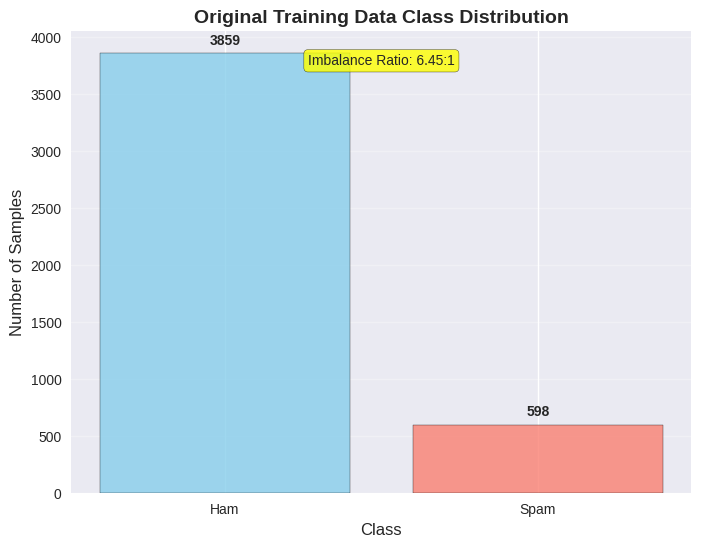

In [16]:
print("\n1. Visualizing Original Class Imbalance...")
plt.figure(figsize=(10, 6))
plot_class_distribution(y_train, "Original Training Data Class Distribution")
plt.show()

In [17]:
print("\n2. Applying Different Sampling Techniques...")
techniques = apply_sampling_techniques(X_train, y_train)


2. Applying Different Sampling Techniques...



3. Comparing Sampling Techniques...


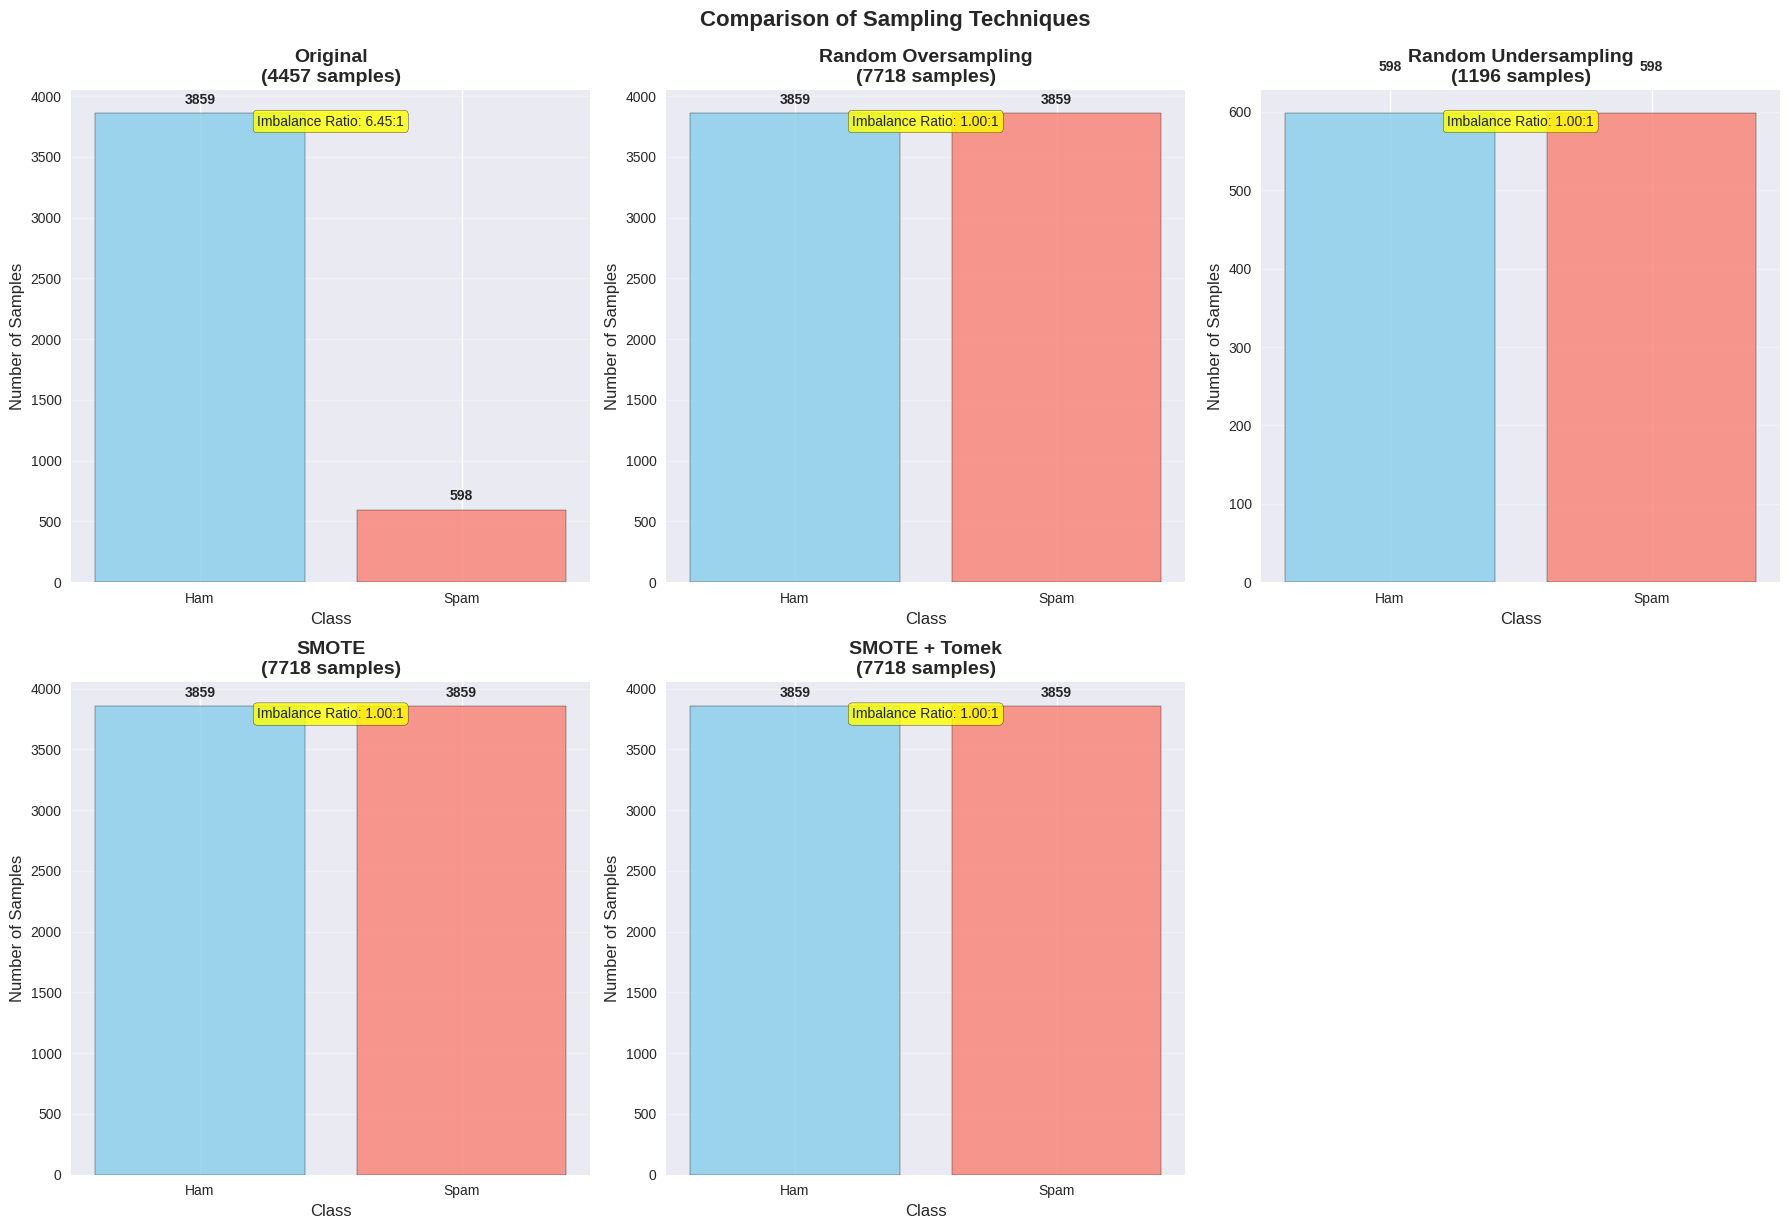

In [18]:
print("\n3. Comparing Sampling Techniques...")
plot_sampling_comparison(techniques)

In [19]:
print("\n4. Training and Evaluating Models...")
results = train_and_evaluate_models(X_train, X_test, y_train, y_test, techniques)


4. Training and Evaluating Models...



5. Performance Comparison...


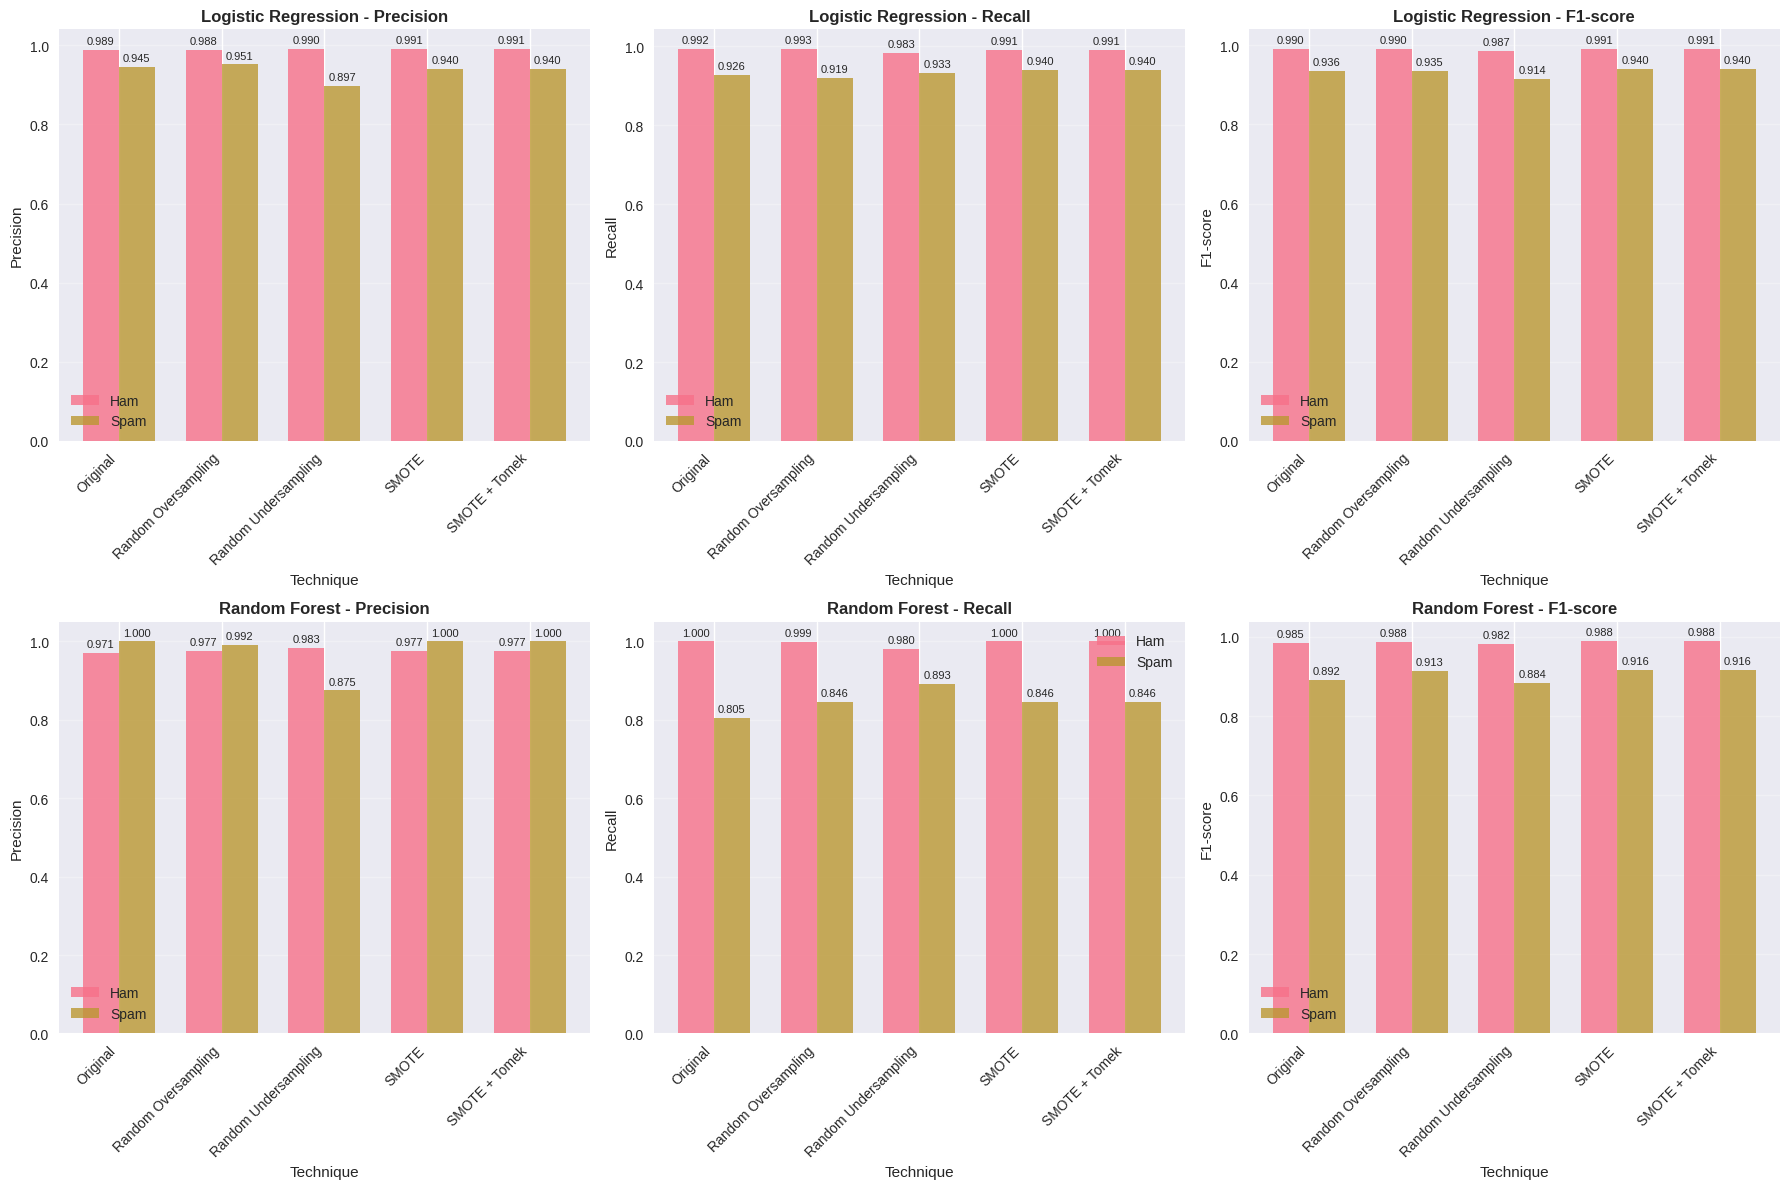

In [20]:
print("\n5. Performance Comparison...")
plot_performance_comparison(results)


6. Confusion Matrices...


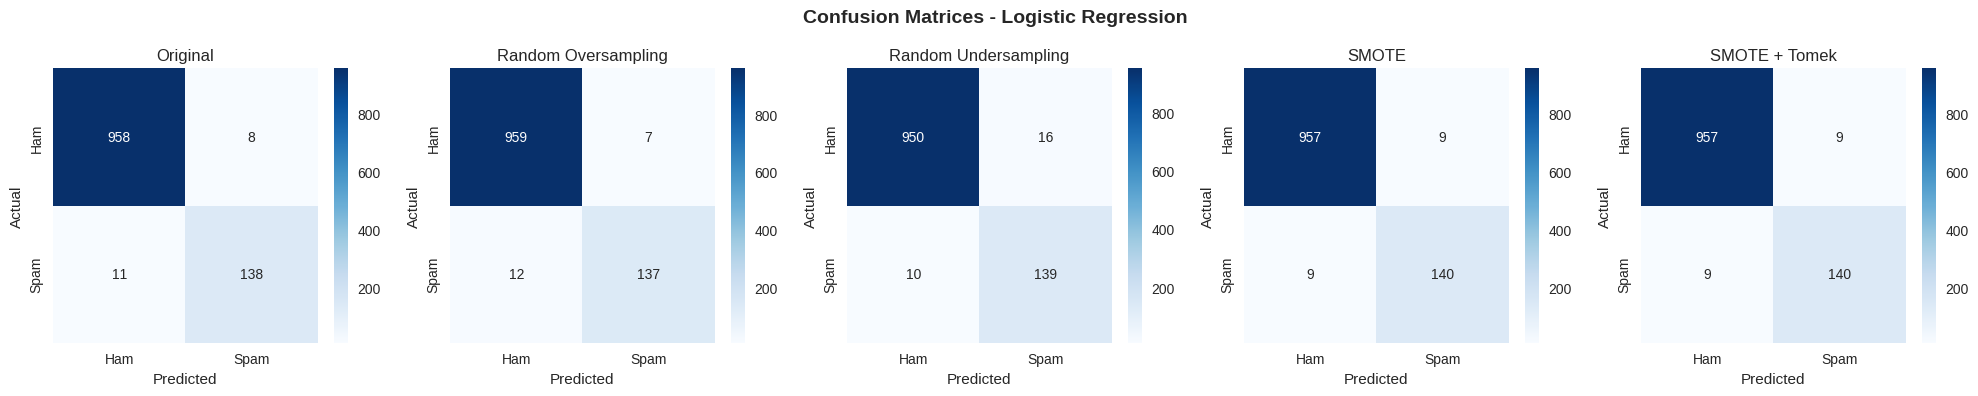

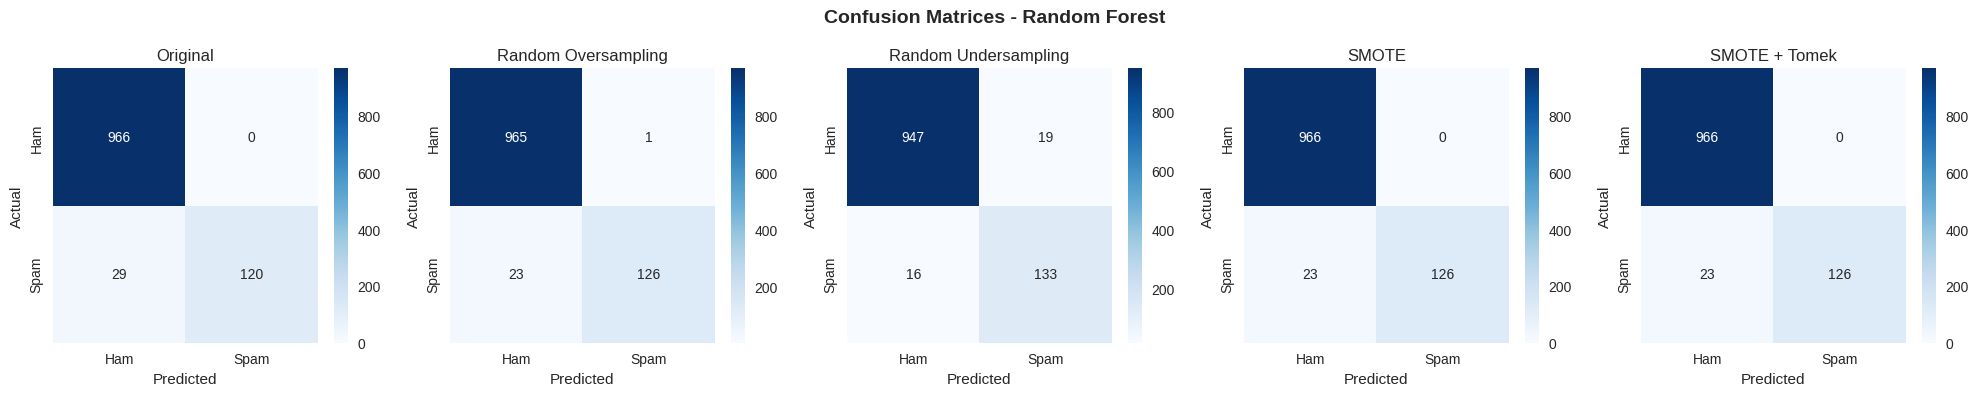

In [21]:

print("\n6. Confusion Matrices...")
plot_confusion_matrices(results, y_test)


7. ROC Curves...


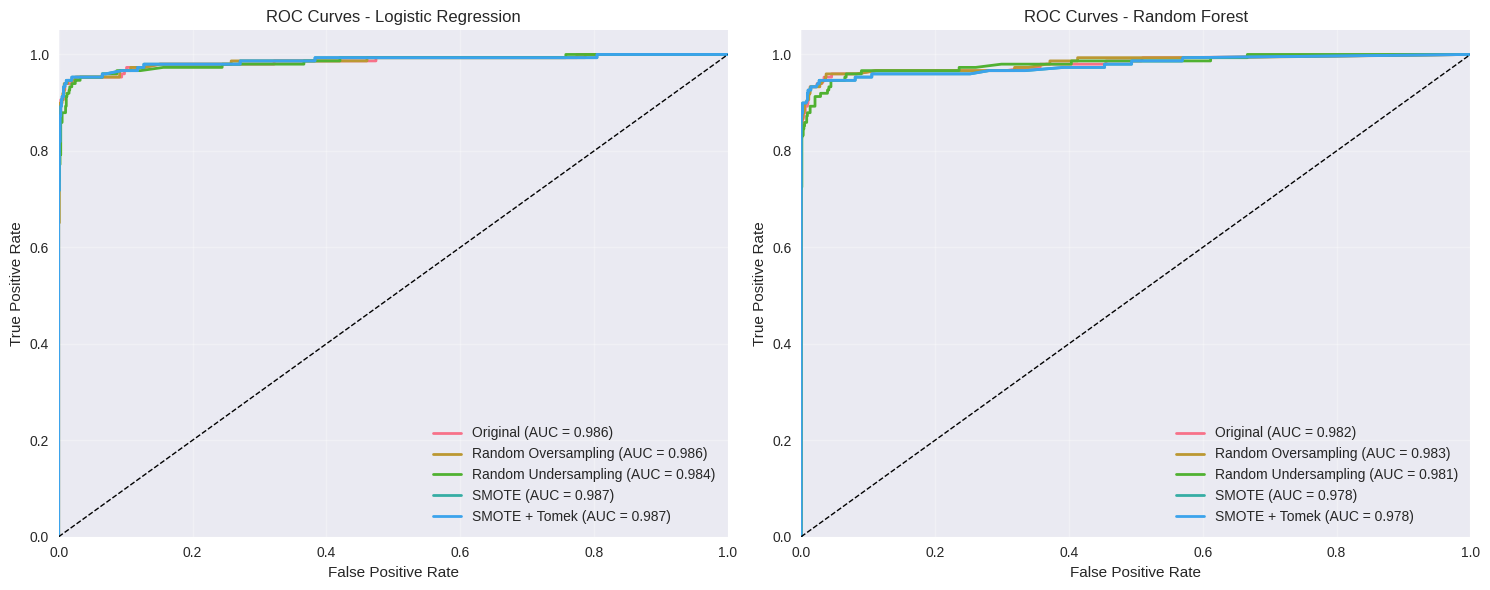

In [22]:
print("\n7. ROC Curves...")
plot_roc_curves(results, y_test)


8. Precision-Recall Curves...


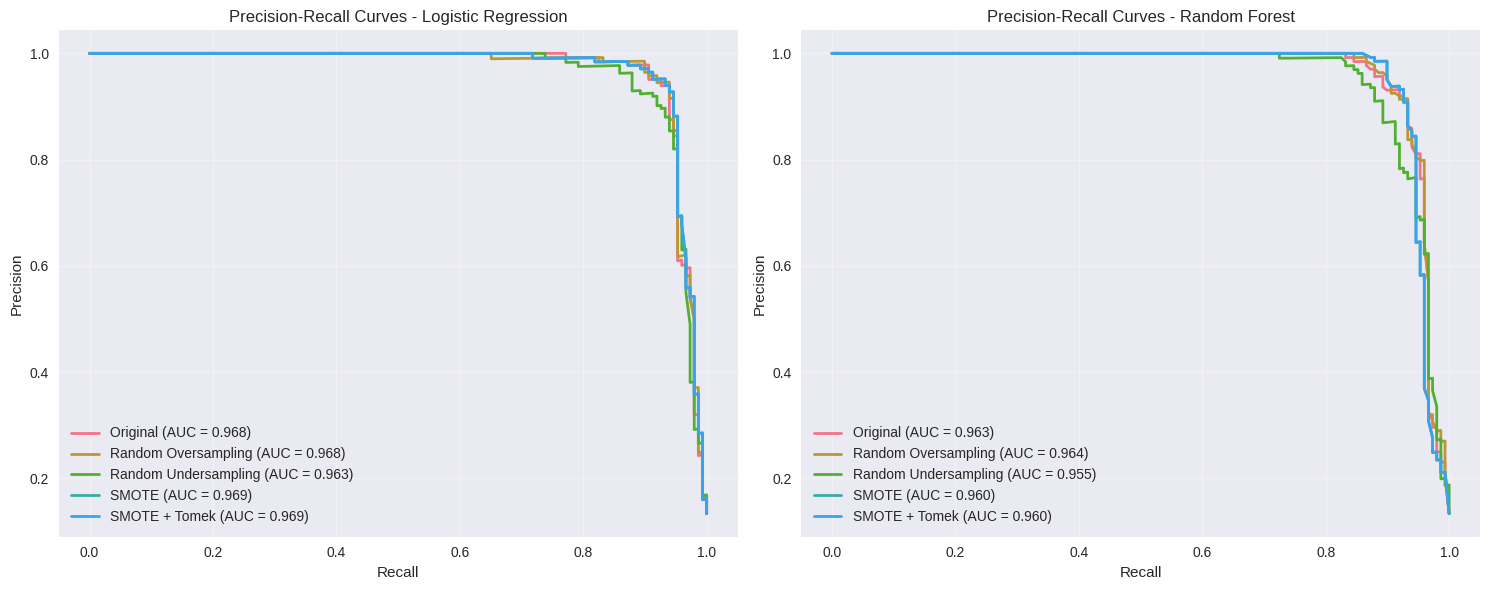

In [23]:

print("\n8. Precision-Recall Curves...")
plot_precision_recall_curves(results, y_test)


9. Performance Summary Table...


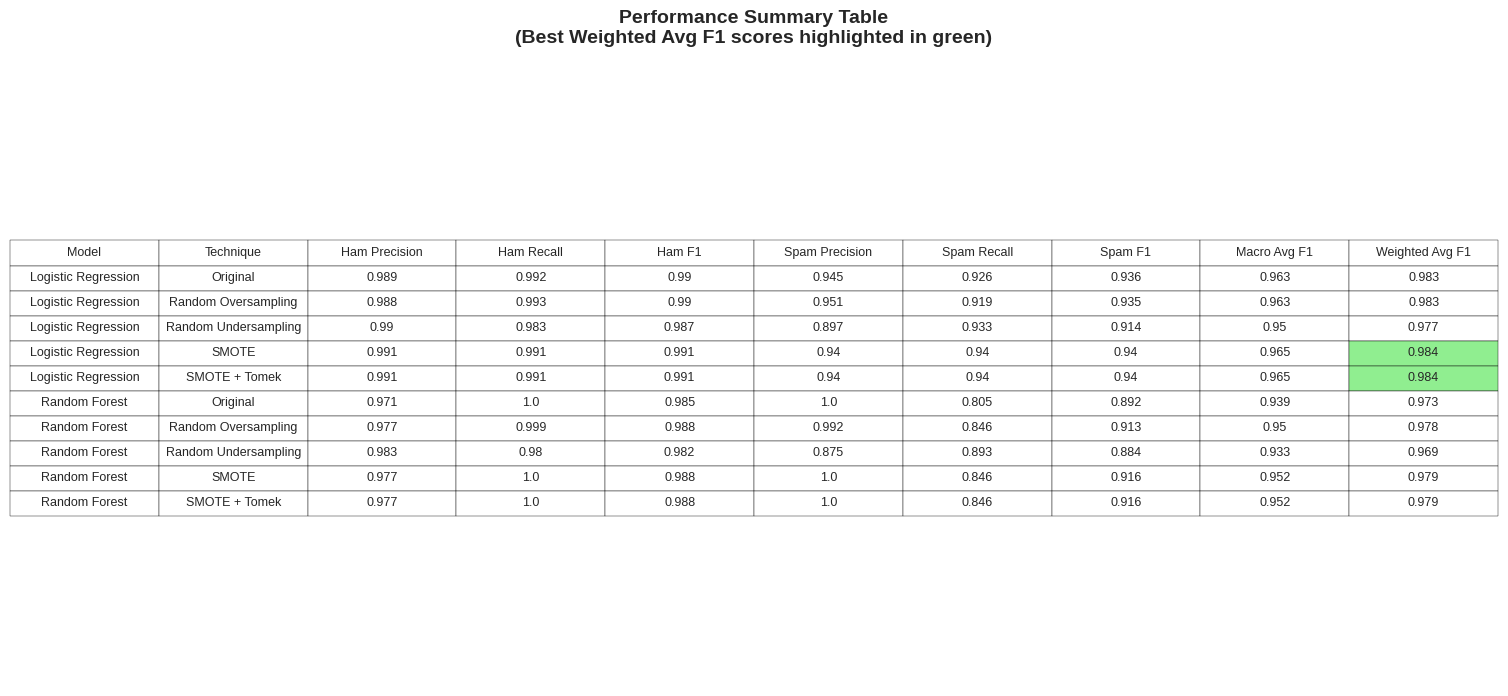

In [24]:
print("\n9. Performance Summary Table...")
summary_df = create_performance_summary_table(results)

In [25]:
best_technique = summary_df.loc[summary_df['Weighted Avg F1'].idxmax()]
print(f"\nBest performing combination:")
print(f"Model: {best_technique['Model']}")
print(f"Technique: {best_technique['Technique']}")
print(f"Weighted Avg F1: {best_technique['Weighted Avg F1']:.3f}")


Best performing combination:
Model: Logistic Regression
Technique: SMOTE
Weighted Avg F1: 0.984
